# Logistic Regression - Female Athletes

In [1]:
# Data Imports
import numpy as np
import pandas as pd


# Math
import math

# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# For evaluating our ML results
from sklearn import metrics

# Dataset Import
import statsmodels.api as sm

In [2]:
# Reading csv files
games_women = pd.read_csv('athletes-women.csv')
games_men = pd.read_csv('athletes-men.csv')
athletes = pd.read_csv('athletes-all.csv')

# athletes who made it into the games
games_all = pd.concat([games_women, games_men])
games_women = games_women.drop(columns = ['rank', 'latitude', 'longitude', 'name', 'region'])
games_men = games_men.drop(columns = ['rank', 'latitude', 'longitude', 'name', 'region'])

/Users/allisontao/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = athletes.merge(games_all.drop_duplicates(), on=['athlete_id'],
                   how='left', indicator=True)

In [4]:
# taking only the columns we want
df_all = df[['athlete_id', 'age_x', 'gender', 'height_x', 'weight_x', 'fran_x', 'run5k_x', 'pullups_x', '_merge', 'train', 'experience', 'schedule', 'howlong_x', 'run400_x', 'candj_x', 'snatch_x', 'deadlift_x', 'backsq_x']]
df_all = df_all.dropna()

df_all_women = df_all.loc[df_all['gender'] == 'Female']

In [5]:
# ones who have not made it who have stats filled out, temp while cleaning up
def make_columns_numeric(df):    
    not_make = df.loc[df['_merge'] == 'left_only']
    not_make['howlong_x'] = not_make['howlong_x'].str.slice(0, 6)

    col         = 'howlong_x'
    conditions  = [ not_make[col].str.contains("Less"), not_make[col].str.contains("6-12"), not_make[col].str.contains("1-2"), not_make[col].str.contains("2-4"), not_make[col].str.contains("4+") ]
    choices     = [0,1,2,3,4]

    not_make["howlong"] = np.select(conditions, choices)

    not_make['coach'] = np.where(not_make['train'].str.contains("have a coach"), 1, 0)
    not_make['certification'] = np.where(not_make['experience'].str.contains("Level 1"), 1, 0)
    not_make['multiple'] = np.where(not_make['schedule'].str.contains("multiple workouts"), 1, 0)

    return not_make

not_make_women = make_columns_numeric(df_all_women)


<ipython-input-5-1facb267e819>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_make['howlong_x'] = not_make['howlong_x'].str.slice(0, 6)
<ipython-input-5-1facb267e819>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_make["howlong"] = np.select(conditions, choices)
<ipython-input-5-1facb267e819>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [6]:
#not_in_games will contain all athletes that did not make it, with stats, with cleaned up columns
not_in_games_women = not_make_women[['athlete_id', 'age_x', 'height_x', 'weight_x', 'fran_x', 'run5k_x', 'pullups_x', 'run400_x', 'candj_x', 'snatch_x', 'deadlift_x', 'backsq_x','howlong','coach','certification','multiple']]
not_in_games_women.rename(columns={"age_x": "age",'height_x': 'height', 'weight_x':'weight', 'fran_x':'fran', 'run5k_x':'run5k','pullups_x':'pullups', 'run400_x':'run400', 'candj_x':'candj', 'snatch_x':'snatch', 'deadlift_x':'deadlift', 'backsq_x':'backsq'}, inplace = True)

/Users/allisontao/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [7]:
#Min and Max of women
not_in_games_women2 = not_in_games_women.loc[(not_in_games_women["age"] >= 18) & (not_in_games_women["height"] <= 108) & (not_in_games_women["height"] >= 50) & (not_in_games_women["weight"] <= 1400) & (not_in_games_women["weight"] >= 100) &(not_in_games_women["fran"] <= 600) & (not_in_games_women["fran"] >= 113) & (not_in_games_women["run400"] <= 180) & (not_in_games_women["run5k"] >= 769)]
not_in_games_women2.agg([min, max])



athlete_id   age  height  weight   fran   run5k  pullups  run400  candj  \
min      1659.0  18.0    58.0   100.0  125.0   945.0      0.0    51.0    0.0   
max    591544.0  55.0    74.0   235.0  600.0  2565.0    100.0   170.0  355.0   

     snatch  deadlift  backsq  howlong  coach  certification  multiple  
min     0.0       0.0     0.0        0      0              0         0  
max   285.0     606.0   551.0        4      1              1         1

In [8]:
games_women['in_games'] = 1
not_in_games_women2['in_games'] = 0

<ipython-input-8-616d7dcee3e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_in_games_women2['in_games'] = 0


In [9]:
df_women = not_in_games_women2.append(games_women)

# Drop ID column
df_women = df_women.drop(['athlete_id'],axis=1)

# Histograms

In [10]:
df_women.groupby('in_games').mean()

age     height      weight        fran        run5k  \
in_games                                                              
0         33.402162  64.953514  140.625946  325.701622  1487.611892   
1         36.616071  64.821429  140.312500  199.950893  1322.553571   

            pullups     run400       candj      snatch    deadlift  \
in_games                                                             
0         23.742703  83.149189  151.607568  114.723243  269.122162   
1         43.200893  76.504464  190.852679  150.482143  315.214286   

              backsq   howlong     coach  certification  multiple  
in_games                                                           
0         213.848649  2.945946  0.435676       0.518919  0.490811  
1         260.504464  2.982143  0.633929       0.589286  0.665179

In [11]:
#Separating in and not in games
df_women_ingames = df_women.loc[df_women['in_games'] == 1]
df_women_nogames = df_women.loc[df_women['in_games'] == 0]

### Age

Text(0.5, 1.0, 'Overlapping plots')

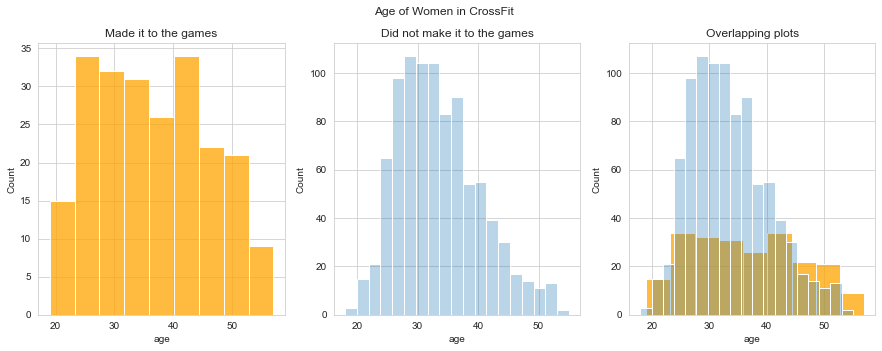

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Age of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="age", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="age", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="age", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="age", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Weight

Text(0.5, 1.0, 'Overlapping plots')

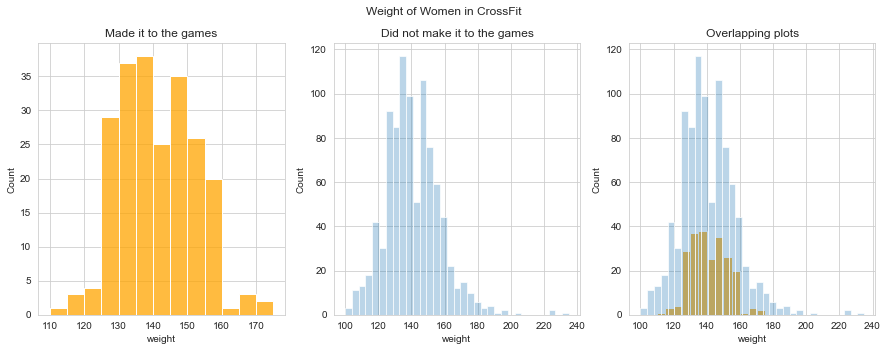

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Weight of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="weight", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="weight", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="weight", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="weight", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Height

Text(0.5, 1.0, 'Overlapping plots')

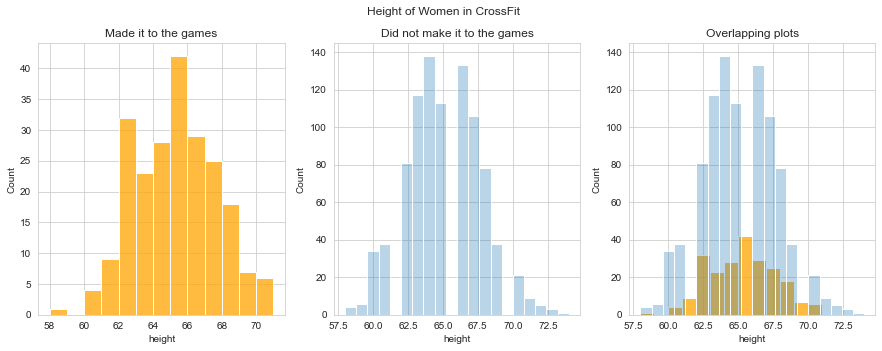

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Height of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="height", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="height", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="height", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="height", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Fran

Text(0.5, 1.0, 'Overlapping plots')

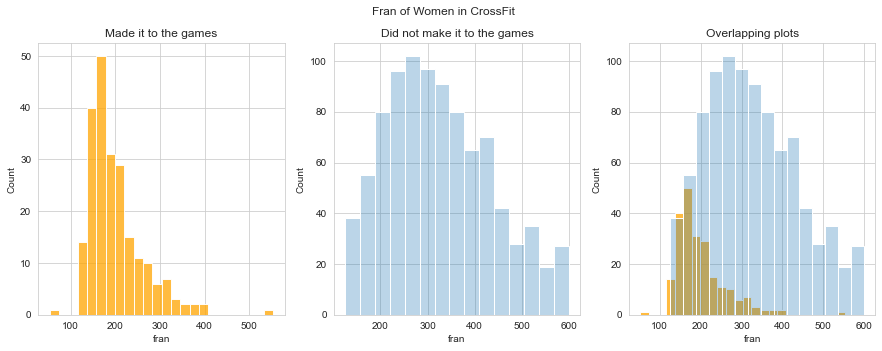

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Fran of Women in CrossFit")

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="fran", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="fran", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="fran", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="fran", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Run5k

Text(0.5, 1.0, 'Overlapping plots')

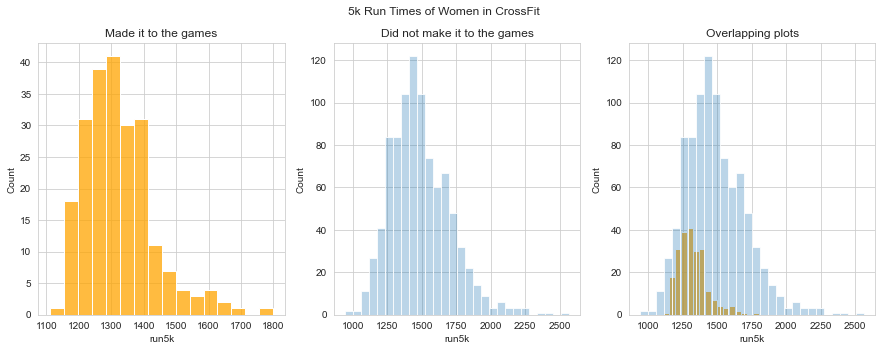

In [117]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('5k Run Times of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="run5k", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="run5k", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="run5k", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="run5k", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Run400

Text(0.5, 1.0, 'Overlapping plots')

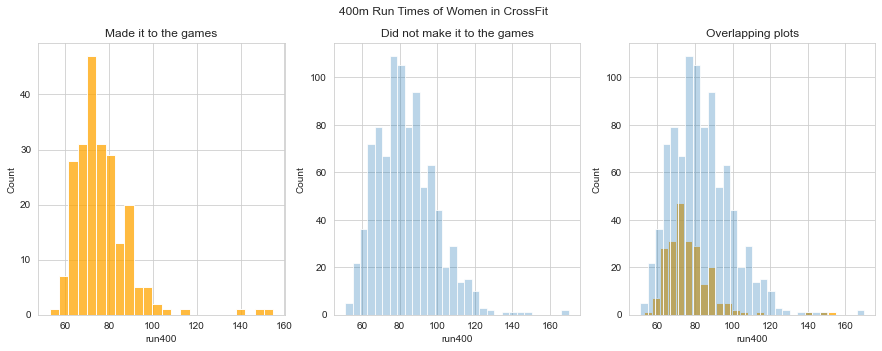

In [118]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('400m Run Times of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="run400", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="run400", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="run400", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="run400", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Clean and Jerk (candj)

Text(0.5, 1.0, 'Overlapping plots')

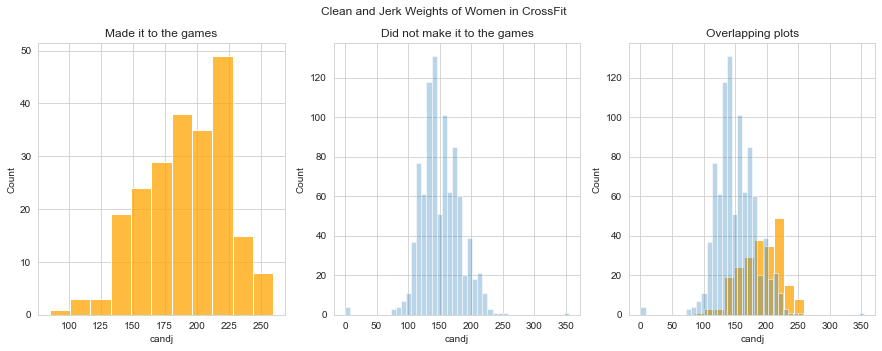

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Clean and Jerk Weights of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="candj", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="candj", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="candj", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="candj", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Snatch

Text(0.5, 1.0, 'Overlapping plots')

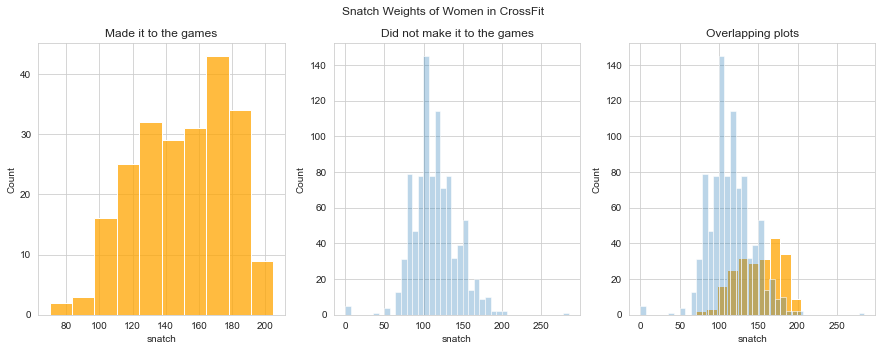

In [120]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Snatch Weights of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="snatch", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="snatch", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="snatch", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="snatch", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Back Squat (backsq)

Text(0.5, 1.0, 'Overlapping plots')

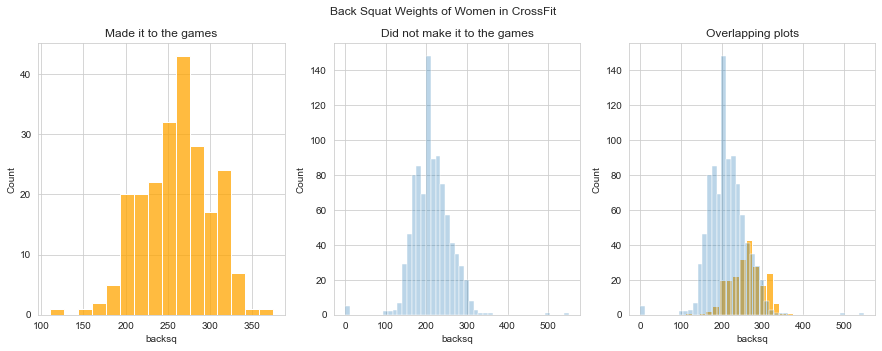

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Back Squat Weights of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="backsq", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="backsq", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="backsq", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="backsq", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Deadlift

Text(0.5, 1.0, 'Overlapping plots')

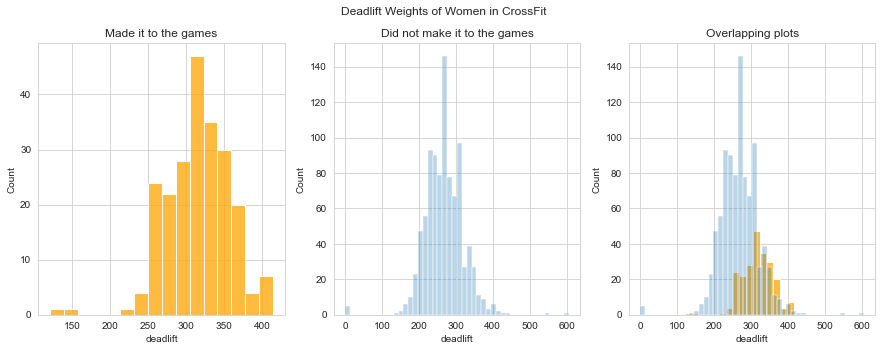

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Deadlift Weights of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="deadlift", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="deadlift", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="deadlift", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="deadlift", alpha=0.3)
axes[2].set_title("Overlapping plots")

### Pullups

Text(0.5, 1.0, 'Overlapping plots')

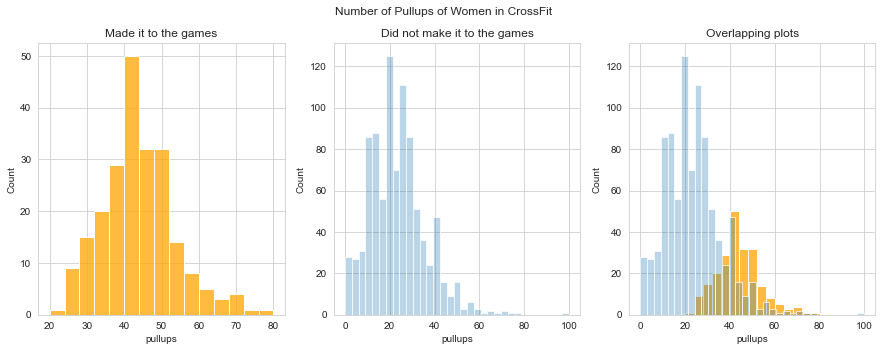

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Number of Pullups of Women in CrossFit')

# In games
sns.histplot(ax=axes[0],data=df_women_ingames, x="pullups", color="orange")
axes[0].set_title("Made it to the games")

# Not
sns.histplot(ax=axes[1],data=df_women_nogames, x="pullups", alpha=0.3)
axes[1].set_title("Did not make it to the games")

#Overlay
sns.histplot(ax=axes[2],data=df_women_ingames, x="pullups", color="orange")
sns.histplot(ax=axes[2],data=df_women_nogames, x="pullups", alpha=0.3)
axes[2].set_title("Overlapping plots")

## Clean up Categorical

In [124]:
# Create Dataframes for Categorical Variables
howlong_women_dummies = pd.get_dummies(df_women['howlong']) # women athletes

howlong_women_dummies

0  1  2  3  4
64482   0  0  0  1  0
97672   0  0  1  0  0
144480  0  0  1  0  0
159571  0  0  0  0  1
159574  0  0  0  0  1
...    .. .. .. .. ..
219     0  0  0  0  1
220     0  0  1  0  0
221     0  1  0  0  0
222     0  0  0  1  0
223     0  0  0  1  0

[1152 rows x 5 columns]

In [125]:
# Create column names for the new DataFrames
howlong_women_dummies.columns = ['hl1','hl2','hl3','hl4','hl5']

In [126]:
# Set X as new DataFrame without the howlong columns or the Y target
X_w = df_women.drop(['howlong'],axis=1)

In [127]:
# Now Concat the X DataFrame with the dummy variables
X_w = pd.concat([X_w,howlong_women_dummies],axis=1)

# Preview of Result
X_w.head()

age  height  weight   fran   run5k  pullups  run400  candj  snatch  \
64482   32.0    66.0   135.0  264.0  1355.0     36.0    75.0  165.0   125.0   
97672   32.0    69.0   185.0  455.0  2172.0     20.0   137.0  115.0    85.0   
144480  40.0    64.0   168.0  380.0  1753.0      6.0   108.0  140.0    90.0   
159571  29.0    64.0   135.0  159.0  1195.0     44.0    65.0  210.0   163.0   
159574  34.0    61.0   130.0  164.0  1269.0     37.0    70.0  173.0   138.0   

        deadlift  backsq  coach  certification  multiple  in_games  hl1  hl2  \
64482      266.0   195.0      1              0         0         0    0    0   
97672      205.0   155.0      0              0         0         0    0    0   
144480     295.0   225.0      1              0         1         0    0    0   
159571     330.0   270.0      1              1         1         0    0    0   
159574     333.0   253.0      0              1         1         0    0    0   

        hl3  hl4  hl5  
64482     0    1    0  
97672     1    0    0  
144480    1    0    0  
159571    0    0    1  
159574    0    0    1

In [128]:
# Set Y as Target class, in games, for men and women
Y_w = df_women.in_games

# Preview
Y_w

64482     0
97672     0
144480    0
159571    0
159574    0
         ..
219       1
220       1
221       1
222       1
223       1
Name: in_games, Length: 1152, dtype: int64

In [129]:
# Dropping one column of each dummy variable set to avoid multicollinearity
X_w = X_w.drop(['hl1'],axis=1)

# Drop affairs column so Y target makes sense
X_w = X_w.drop(['in_games'],axis=1)

# Preview
X_w.head()

age  height  weight   fran   run5k  pullups  run400  candj  snatch  \
64482   32.0    66.0   135.0  264.0  1355.0     36.0    75.0  165.0   125.0   
97672   32.0    69.0   185.0  455.0  2172.0     20.0   137.0  115.0    85.0   
144480  40.0    64.0   168.0  380.0  1753.0      6.0   108.0  140.0    90.0   
159571  29.0    64.0   135.0  159.0  1195.0     44.0    65.0  210.0   163.0   
159574  34.0    61.0   130.0  164.0  1269.0     37.0    70.0  173.0   138.0   

        deadlift  backsq  coach  certification  multiple  hl2  hl3  hl4  hl5  
64482      266.0   195.0      1              0         0    0    0    1    0  
97672      205.0   155.0      0              0         0    0    1    0    0  
144480     295.0   225.0      1              0         1    0    1    0    0  
159571     330.0   270.0      1              1         1    0    0    0    1  
159574     333.0   253.0      0              1         1    0    0    0    1

In [130]:
# Flatten array
Y_w = np.ravel(Y_w)

# Check result
Y_w

array([0, 0, 0, ..., 1, 1, 1])

# Logistic Regression

In [131]:
# Create LogisticRegression model
log_model_w = LogisticRegression()

# Fit our data
log_model_w.fit(X_w,Y_w)

# Check our accuracy
log_model_w.score(X_w,Y_w)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8854166666666666

In [132]:
# Check percentage of women that made it to the games
Y_w.mean()

0.19444444444444445

In [133]:
# Use zip to bring the column names and the np.transpose function to bring together the coefficients from the model
coeff_df_w = pd.DataFrame(zip(X_w.columns,np.transpose(log_model_w.coef_)))
coeff_df_w

0                         1
0             age     [0.13188300759691232]
1          height    [-0.12017073841870657]
2          weight  [-0.0036719283918102905]
3            fran   [-0.004498531419721372]
4           run5k   [-0.003896914894081673]
5         pullups    [0.048395853086409854]
6          run400    [0.011239558974799113]
7           candj      [0.0192593439885912]
8          snatch    [0.022804019439910825]
9        deadlift  [-0.0013089836144267398]
10         backsq   [0.0012654853330719223]
11          coach    [0.008072899246875365]
12  certification   [-0.019964363657884555]
13       multiple  [-0.0018409673615070862]
14            hl2    [0.008265100725925381]
15            hl3    [0.009349024242111982]
16            hl4   [-0.008490570704242953]
17            hl5   [-0.013187784115992394]

#### Testing and Training Sets

In [134]:
# Split the data
X_w_train, X_w_test, Y_w_train, Y_w_test = train_test_split(X_w,Y_w)

# Make a new log_model
log_model2_w = LogisticRegression()

# Now fit the new model
log_model2_w.fit(X_w_train,Y_w_train)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Confusion Matrix

In [135]:
# Predict the classes of the testing data set
class_predict_w = log_model2_w.predict(X_w_test)


# Compare the predicted classes to the actual test classes
metrics.accuracy_score(Y_w_test,class_predict_w)

0.875

In [136]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

def confusion_matrix(y, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm

confusion_matrix(Y_w_test, class_predict_w)

error rate: 0.12


Predicted label    0   1
True label              
0                218  10
1                 26  34